<a href="https://colab.research.google.com/github/Renshui-MC/Physics-based-deep-learning/blob/main/Navier%20stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Model**

##**Navier-Stokes Forward Simulation**

###Continuity equation
$$\frac{\partial \rho}{\partial t} + \rho \frac{\partial u_{i}}{\partial x_j} = 0$$ ($\rho$ is constant for incompressible flows.)

###Momentum Equation (Navier-stokes Equation)
$$\frac{\partial u_{i}}{\partial t} + u_{j}\frac{\partial u_{i}}{\partial x_j} = -\frac{1}{\rho}\frac{\partial}{\partial x_j}(P+\rho g z) + \nu \frac{u^{2}_{i}}{\partial x_j \partial x_j}$$

+ $\rho$ is constant
+ **Dirichlet boundary condition for velocity** $u_i$ = 0
+ **Neumann boundary condition for pressure** $\frac{\partial p}{\partial x_j} = 0$
+ A 2D Spatial domain ($\Omega$): $100 \times 80$ box size
+ $32 \times 40$ interested domain window

In [140]:
!pip install --upgrade --quiet phiflow==2.2
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.flow import *  # The Dash GUI is not supported on Google colab, ignore the warning
import pylab

##**Mesh generation and set up the simulation**

+ Sphere geometry (centered at $30$ and $15$)
+ Smoke flow
+ box size = $80 \times 100$
+ `extrapolation.BOUNDARY`: **Neumann boundary condition**
+ `extrapolation.ZERO`: **Extrapolates with the constant value zero (Dirichlet boundary condition)**
+ `CenteredGrid(Values: Any, extrapolation: Any = 0.0)`: inside `1` and outside `0` 

An `INFLOW` of smoke is a **field** and can be generated using `CenteredGrid`.

+ `CenteredGrid`, `StaggeredGrid`, and `Noise`, and `PointCloud` are important subclasses of the base class `Field` (Note `phi.Field` is a super-module in `phiflow`.).
+ `CenteredGrid` and `StaggeredGrid` subclasses are important subclasses of the `Grid` class 
+ `CenteredGrid` is n-dimensional grid with values sampled at the cell centers. The first argment `CenteredGrid.values` (`Geometry`, `Field`, etc) is a `Tensor`.
+ The `Geometry` class is a base class to the subclass `sphere`.

 The smoke is in a **sphere** shape generated from the `sphere` class.   


In [141]:
DT = 1.5
NU = 0.01

INFLOW = CenteredGrid(Sphere(center=tensor([30,15], channel(vector='x,y')), radius=10), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100))) * 0.2


Generate mesh to simulate a **velocity field** and a **smoke density field.** staggered mesh is used for velocity field. `Geometry`: sets outside values to $0$. Variable `Smoke` is an instance of `CenteredGrid`, which is a drived class of `Grid`.

In [142]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled in staggered form at face centers 

`at(centeredfield)` is a method of the `field` class. It samples this field at the sample points, e.g., `CenteredField`. It returns a **field** object, not a **Tensor** (`Field.sample()` returns a Tensor). It can make `SampledField` with different different sampling points compatible through **interpolation**.  

`semi_lagrangian` is a function: `(first argument, second argument, third argument)`
+ first argument: quantity to be advected, stored on a grid
+ second argument: vector field that needs to be compatible with field
+ third argument: `dt` time increment

`smoke * (0, buoyancy_factor)` is to turn the smoke field into a **staggered, 2 component force field** sampled at the velocity field via `at()`.  

`make_incompressible` solves a Poisson equation represented by a system of linear algebraic equations. This is the most expensive step.

Max. velocity and mean marker density: [0.1558497, 0.008125]


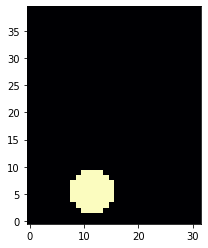

In [143]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)
    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

##**Datatypes and dimensions**

Since `CenteredClass` is a derived class of `Grid`, the instances such as `smoke` and `velocity` can access the methods of `Grid`, e.g., `shape` function.

Example: `smoke.shape` and `velocity.shape`

`s` stands for **spatial dimensions** and `v` stands for **vector dimensions**.

In [144]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}, spatial only: {INFLOW.shape.spatial}")

Smoke: (xˢ=32, yˢ=40)
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y)
Inflow: (xˢ=32, yˢ=40), spatial only: (xˢ=32, yˢ=40)


Further, `shape.sizes` returns the content of the object, and `shape.get_size('dim')` gets the dimension. Note that `dim` must be a `Tuple`.

In [145]:
print(f"Shape content: {velocity.shape.sizes}")
print(f"Vector dimension: {velocity.shape.get_size('vector')}")

Shape content: (32, 40, 2)
Vector dimension: 2


you can also access grid values via `.values`.

In [146]:
print("Statistics of the different simulation grids:")
print(smoke.values)
print(velocity.values)
print(INFLOW.values)
print(smoke.resolution)
print("smoke resolution = "+format(smoke.resolution))
print("smoke box = "+format(smoke.box))

# in contrast to a simple tensor:
test_tensor = math.tensor(numpy.zeros([3, 5, 2]), spatial('x,y'), channel(vector="x,y"))
print("Reordered test tensor shape: " + format(test_tensor.numpy('vector,y,x').shape) ) # reorder to vector,y,x 
#print(test_tensor.values.numpy('y,x')) # error! tensors don't return their content via ".values"

Statistics of the different simulation grids:
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(xˢ=(x=31, y=32), yˢ=(x=40, y=39), vectorᶜ=x,y) -7.23e-09 ± 5.3e-03 (-1e-01...2e-01)
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(xˢ=32, yˢ=40)
smoke resolution = (xˢ=32, yˢ=40)
smoke box = Box(x=(0, 80), y=(0, 100))
Reordered test tensor shape: (2, 5, 3)


##**Time advancement**

To advance in time for `10` times. At each time step, the field is updated.

In [147]:
for time_step in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {}, max velocity {}'.format(time_step , np.asarray(math.max(velocity.values)) ))

Computed frame 0, max velocity 0.463001
Computed frame 1, max velocity 0.896646
Computed frame 2, max velocity 1.4098884
Computed frame 3, max velocity 2.0411277
Computed frame 4, max velocity 2.927958
Computed frame 5, max velocity 3.8394766
Computed frame 6, max velocity 4.526946
Computed frame 7, max velocity 4.867982
Computed frame 8, max velocity 5.13108
Computed frame 9, max velocity 5.4838786


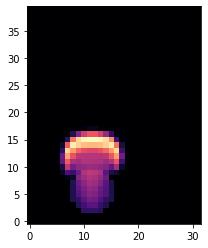

In [128]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

x: `velocity.values.vector[0]`, and y: `velocity.values.vector[1]`

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10


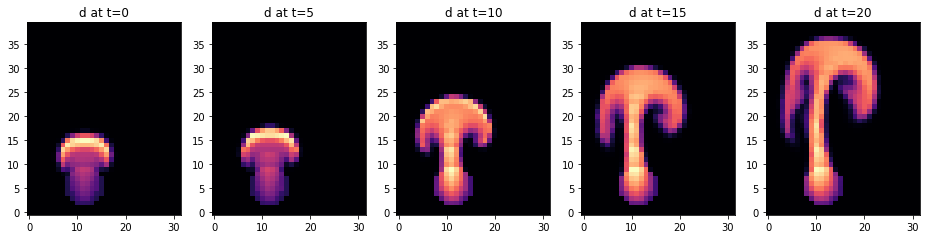

In [148]:
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
for time_step in range(20):
  if time_step<3 or time_step%10==0: 
    print('Computing time step %d' % time_step)
  velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
  if time_step%5==0:
    steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*5}")

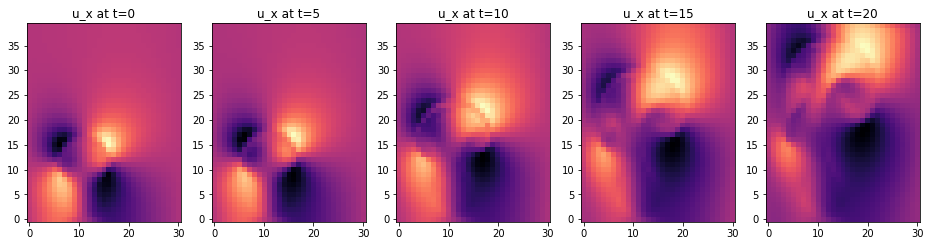

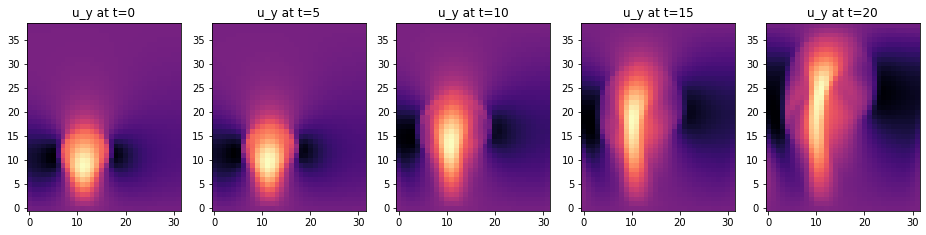

In [149]:
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_x at t={i*5}")
    
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_y at t={i*5}")
    